In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# constants

%matplotlib inline
pd.set_option('precision', 2) # 2 decimal places
sns.set(style="ticks", color_codes=True)

native = "native"
wasm = "wasm"
distributed = "Distributed"
local = "Local"
types = [native, wasm]

tiny = "Tiny"
small = "Small"
big = "Big"
huge = "Huge"
loop_sizes = [tiny, small, big]

nt = "Number of threads"
st = "System"
tt = "Time (ms)"
lt = "Loop size"
ht = "Throughput (ops/msec)"

columns = [lt, nt, st, tt]

palette = {native: "g", wasm: "m", local: "m", distributed: "c"}

real_size = {
    tiny: 200000,
    small: 20000000,
    big: 200000000,
    huge: 2 * 900000000,
}

def add_throughput(df):
    for index, row in df.iterrows():
        df.loc[index, ht] = real_size[row[lt]]/ row[tt]

## Native versus Wasm (single host)

The plot below looks at how our libraries perform distributing work on a 20 cores machines. 

**Note** 
* The native library uses a thread pool, we dynamically generate threads when needed.

In [7]:
all_musl = pd.read_csv("nativeVwasm/all-musl.csv", header=0, names=columns)
all_musl.head(1)

,Loop size,Number of threads,System,Time (ms)
0,Tiny,1,native,11916


In [8]:
add_throughput(all_musl)
all_musl.head(1)

,Loop size,Number of threads,System,Time (ms),Throughput (ops/msec)
0,Tiny,1,native,11916,16.78


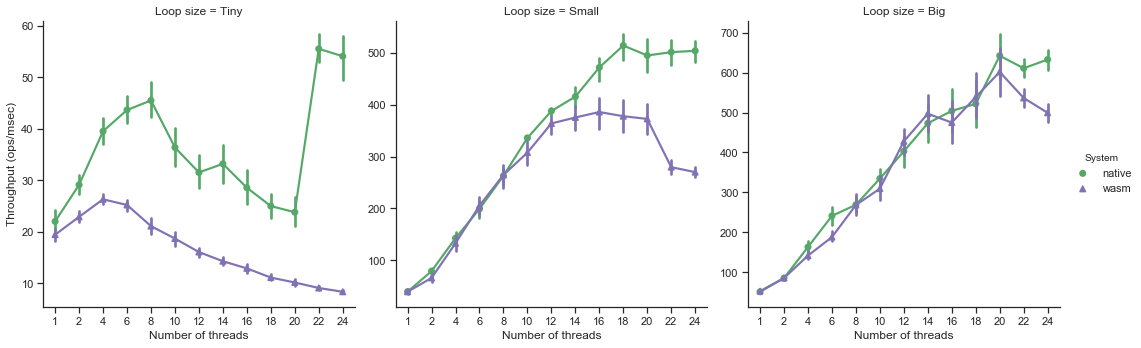

In [33]:
g = sns.catplot(x=nt, y=ht, hue=st,
                col=lt, sharey=False,
                palette=palette,
                markers=["o", "^"],
                scale=0.8,
                kind="point",
                data=all_musl)

Here is the same plot but looking at time.

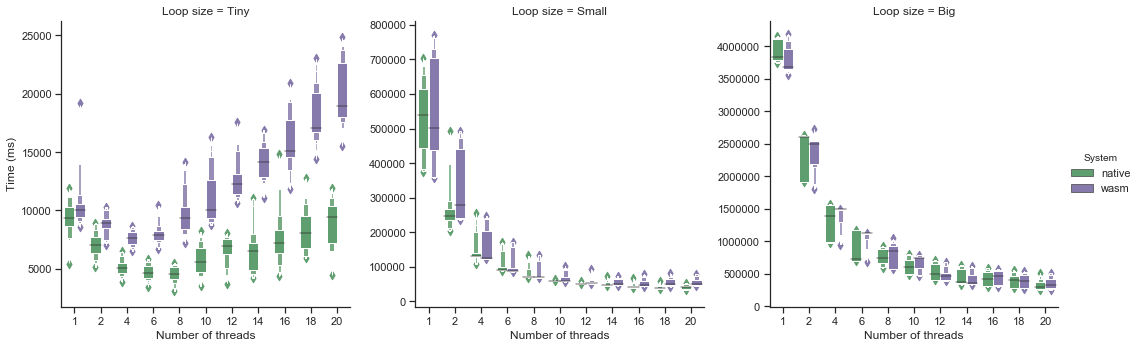

In [20]:
g = sns.catplot(x=nt, y=tt, hue=st,
                col=lt, sharey=False,
                palette=palette,
                kind="boxen",
                data=all_musl[all_musl[nt] <= 20])

## Distributed experiments

### Linear throughput experiment

#### 20 threads local versus 2x10 distributed

In [17]:
d1 = pd.read_csv("distributed/10TperWorker.csv", header=0, names=columns)
d1.head(1)

,Loop size,Number of threads,System,Time (ms)
0,Small,1,Local,616013


In [18]:
add_throughput(d1)
d1.head(1)

,Loop size,Number of threads,System,Time (ms),Throughput (ops/msec)
0,Small,1,Local,616013,32.47


For the graphs below, we note that the `local` version is limited to 20 threads, when the 2 distributed workers are configured as follows:
```
  THREADS_PER_WORKER=12,
  MAX_IN_FLIGHT_RATIO=1,
  MAX_WORKERS_PER_FUNCTION=10,
```

**Interesting things to note:**
* On both graphs, there seem to be a perfectly linear trend for the distributed case for 10 threads onwards!
* From 22 threads, there seem to be a lot of thrashing, due to the node saturation. I need to find out what's going on exactly here
* We note that for the small loop size, the distributed worker is faster, probably because of its pool design compared to dynamic thread creation for the local case which might explain why the distributed case is so much faster.

_TODOs_
* Re-run experiment with limit of 10 (or 20) for the local node parallelism, that will better distinguish the "take over" by the distributed case, this was only useful to show perfect linear extrapolation from one case to the other.
* Figure out what happens past 20 in the distributed case

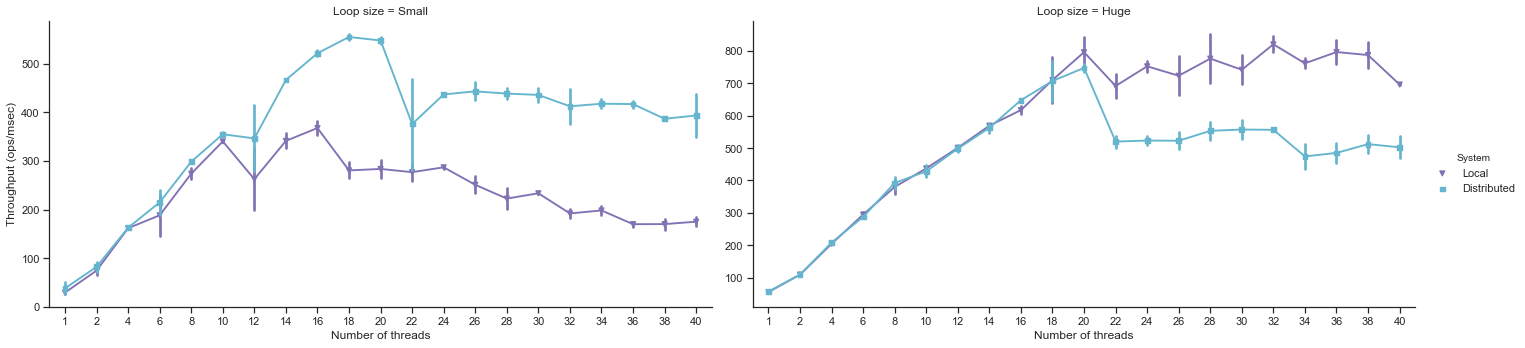

In [34]:
g = sns.catplot(x=nt, y=ht, hue=st,
                col=lt, sharey=False,
                palette=palette,
                markers=["v", "s"],
                aspect=2,
                scale=0.7,
                kind="point",
                data=d1)

Below are continuity graphs from the data above for 10 threads onwards. I include the graph with both sizes together because the large error bars makes it look so much more compeling!

In [50]:
lin_d1 = d1[(d1[nt] <= 20) & ((d1[st] == local) & (d1[nt] <= 10) | ((d1[st] == distributed) & (d1[nt] >= 10) ))]

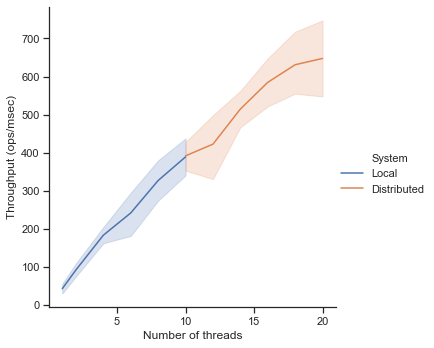

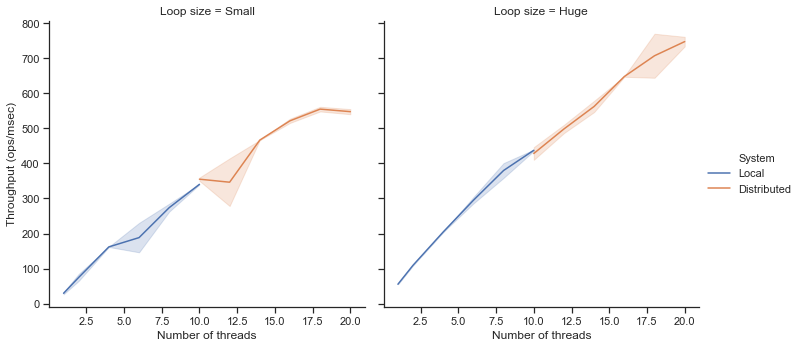

In [55]:
ax1 = sns.relplot(x=nt, y=ht, hue=st, kind="line", data=lin_d1)
ax2 = sns.relplot(x=nt, y=ht, hue=st, col=lt, kind="line", data=lin_d1)

#### 20 threads local versus 2x18 threads distributed database lock

In [142]:
d2 = pd.read_csv("distributed/18TperWorker-huge.csv")
d2.head(1)

,Unnamed: 0,Loop size,Number of threads,System,Time (ms),Throughput (ops/msec)
0,311,Huge,4,Local,45069296,39.94


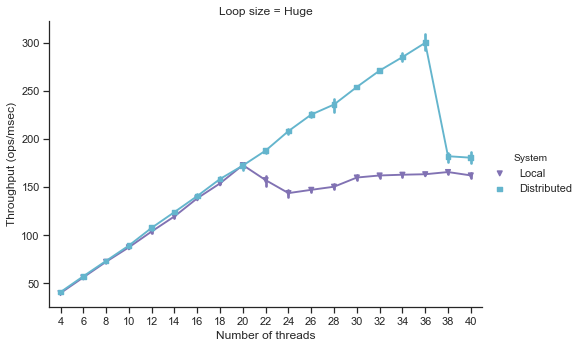

In [147]:
g = sns.catplot(x=nt, y=ht, hue=st,
                col=lt, sharey=False,
                palette=palette,
                markers=["v", "s"],
                aspect=1.4,
                scale=0.7,
                kind="point",
                data=d2)

This time we up the number of threads per worker to 20 to match the local capacity

In [150]:
lin_d2 = d2[(d2[nt] <= 36) & ((d2[st] == local) & (d2[nt] <= 20) | ((d2[st] == distributed) & (d2[nt] >= 20) ))]

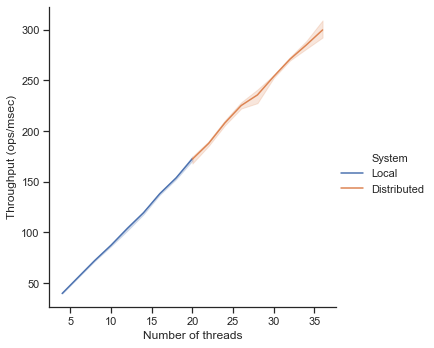

In [151]:
ax1 = sns.relplot(x=nt, y=ht, hue=st, kind="line", data=lin_d2)

### Distributed State experiment

#### Reduction with distributed locking

##### 1 host, collocated redis and worker

In [58]:
tt1 = "Time (ns)"
d3 = pd.read_csv("distributed/10TManyReduce.csv", header=0, names=[nt, st, tt1])
d3.head(3)

,Number of threads,System,Time (ns)
0,1,native-realistic,1183967
1,1,native-warm,2237
2,1,native-warm,607


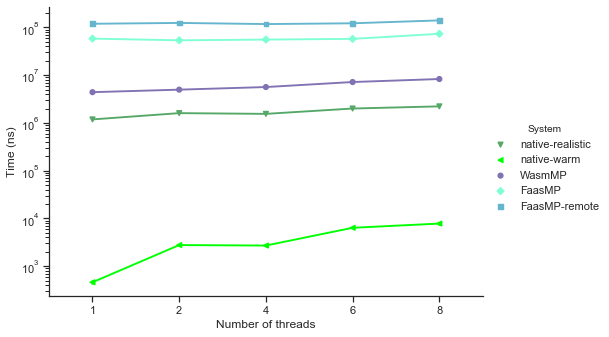

In [59]:
g = sns.catplot(x=nt, y=tt1, hue=st,
                sharey=False,
                palette={"native-realistic": "g", "native-warm": "lime", "WasmMP": "m", "FaasMP": "aquamarine", "FaasMP-remote": "c"},
                markers=["v", "<", "o", "D", "s"],
                aspect=1.4,
                scale=0.7,
                kind="point",
                data=d3[d3[nt] <= 8])
g.ax.set_yscale("log")